<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/FinalRound/Xception_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Compressed Binary Classification Dataset file is stored at: https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0
!wget https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0

--2021-03-10 11:05:20--  https://www.dropbox.com/s/dhu2h2me4ccpe9h/BinaryDataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dhu2h2me4ccpe9h/BinaryDataset.zip [following]
--2021-03-10 11:05:21--  https://www.dropbox.com/s/raw/dhu2h2me4ccpe9h/BinaryDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc266d9f84bacff332d092aadb82.dl.dropboxusercontent.com/cd/0/inline/BKYq5pq22OYZ9UFZTvIjRMA018Iab1ZziK6Pgkpzg_wWWiXUdsJ3BhMBfsxtQsWGLClEWUbV_COTAcOv160LM0lZMZ4miNNrQ-RZmeAHiaeX_KhIP6Urlzz04dldkxoD8aLqxr4phZdkcS6fTgPG2swR/file# [following]
--2021-03-10 11:05:21--  https://uc266d9f84bacff332d092aadb82.dl.dropboxusercontent.com/cd/0/inline/BKYq5pq22OYZ9UFZTvIjRMA018Iab1ZziK6Pgkpzg_wWWiXUdsJ3BhMBfsxtQsWGLClEWU

In [ ]:
#Extracting the compressed dataset
!unzip /content/BinaryDataset.zip?dl=0

In [5]:
#Importing all the libraries required for preprocessing, training and evaluation of the model
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory #Importing Functions for image preprocessing from keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #Importing Functions for early stopping and learning rate reduction
from sklearn.utils import class_weight #Importing functions for computing class weights from scikit learn class_weight module
from keras.utils import plot_model
from keras.preprocessing import image
from keras.layers import *
from keras.models import * #Importing the functions required for creating the model
import matplotlib.pyplot as plt #For plotting the training and validation loss and accuracy graphs
import numpy as np
import pandas as pd

In [6]:
train_images_path = "BinaryDataset/Train"
validation_images_path = "BinaryDataset/Validation"
test_images_path = "BinaryDataset/Test"
image_height = 299 #default input image size for Xception model
image_width = 299

In [7]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training dataset
train_dataset= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (image_height,image_width), 
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "binary", #class mode is binary for binary classification
    shuffle = True,
    seed =50
    )

inp_shape= train_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", train_dataset.class_indices)

Found 3108 images belonging to 2 classes.
Input Shape:  (299, 299, 1)
Class Labels:  {'COVID': 0, 'Non-COVID': 1}


In [8]:
validation_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    validation_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "binary",
    shuffle = True,
    seed =40
    )

validation_dataset.class_indices

Found 388 images belonging to 2 classes.


{'COVID': 0, 'Non-COVID': 1}

In [9]:
test_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the test images 

#Preprocessing the testing dataset
test_dataset = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "binary",
    shuffle = True,
    seed =20
    )

Found 312 images belonging to 2 classes.


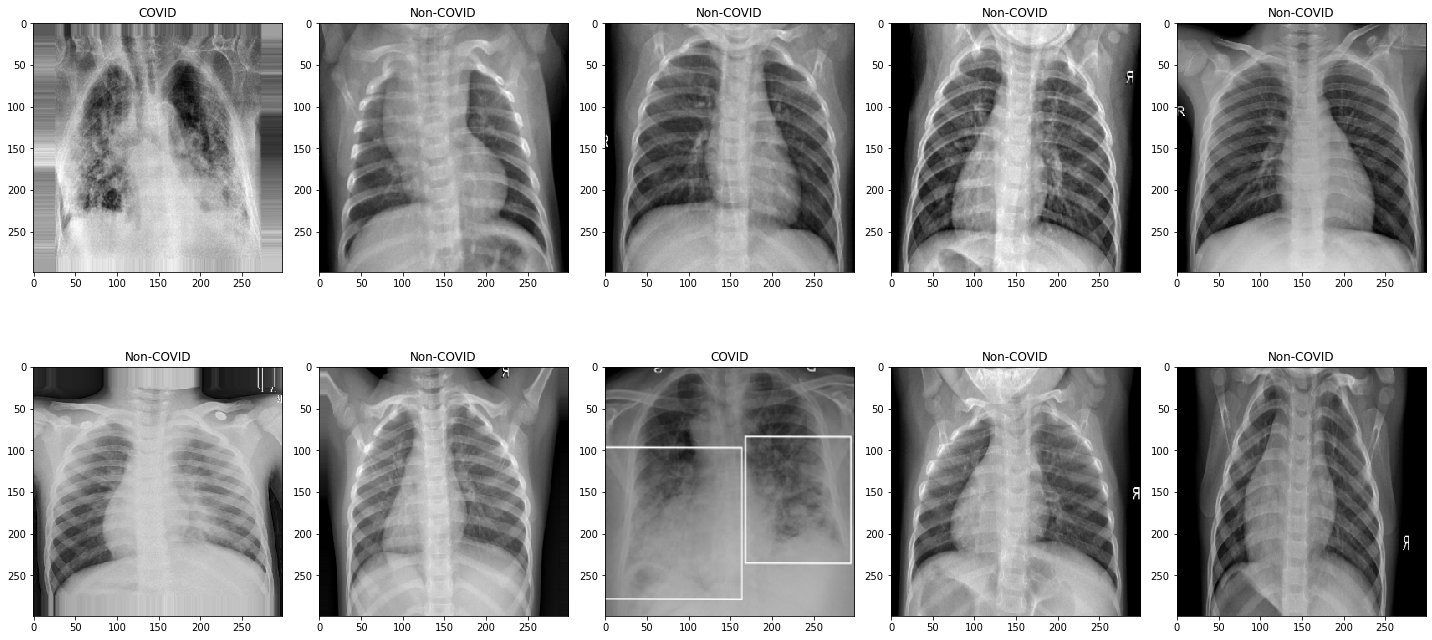

In [10]:
#Visualization of Preprocessed Data
plt.figure(figsize=(20, 10))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_dataset:
        image = X_batch[0]        
        dic = {0: 'COVID', 1:'Non-COVID'} 
        plt.title(dic.get(Y_batch[0])) #to get index of the image label
        plt.axis('on')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [28]:
#Modifying the Xception model for implementing binary classification
baseModel = keras.applications.Xception(weights=None, input_shape=inp_shape, include_top=False, pooling='avg')
for layer in baseModel.layers:
    layer.trainable = False
output = Dense(1, activation='sigmoid')(baseModel.output)
finalXceptionModel = Model(baseModel.input, output)
finalXceptionModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #changed the optimizer from rmsprop to adam

finalXceptionModel.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 288         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

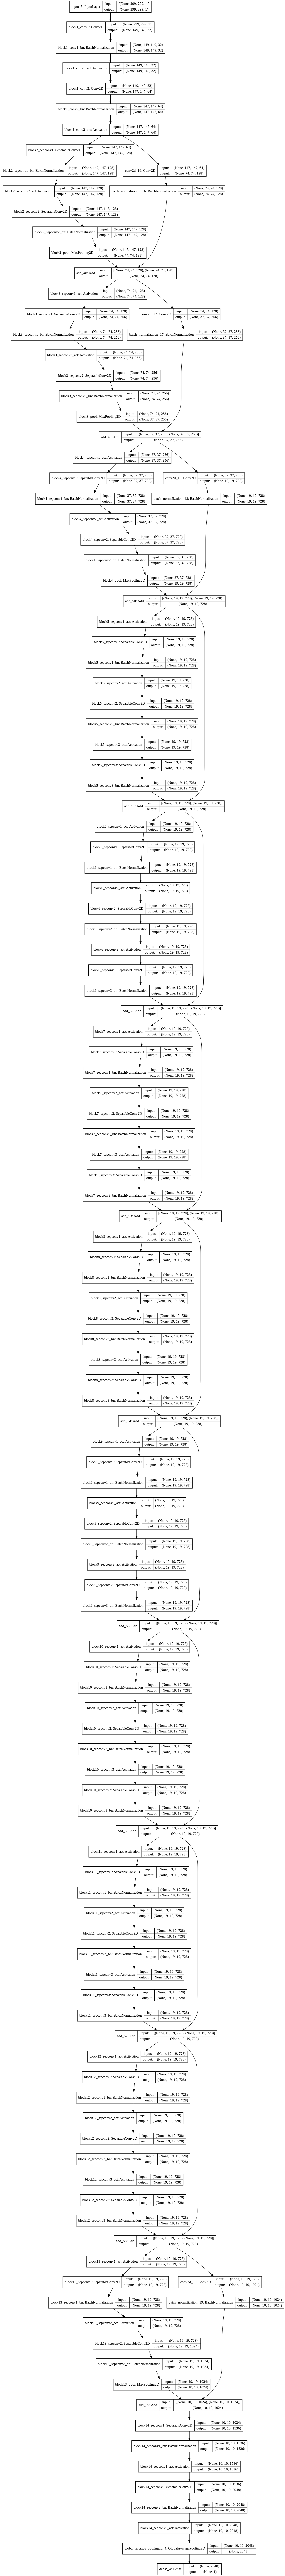

In [29]:
plot_model(finalXceptionModel,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [31]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=validation_dataset.n//validation_dataset.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [34]:
#Functions for early stopping and adjusting the learning rate during model training 
earlyStop = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=4, 
                          verbose= 1)

learningRateReduce = ReduceLROnPlateau(monitor='val_loss', 
                                       patience = 2, 
                                       verbose=1,
                                       factor=0.4, 
                                       min_lr=0.0000001)

callbacksList = [ earlyStop, learningRateReduce]

In [35]:
#Assigning class weights using the compute class weights function
classWeights = class_weight.compute_class_weight('balanced', np.unique(train_dataset.classes), train_dataset.classes)
classWeightsDict = dict(enumerate(classWeights))
print("The class weights assigned to each label are:", classWeightsDict)

The class weights assigned to each label are: {0: 1.61875, 1: 0.723463687150838}


In [36]:
hist = finalXceptionModel.fit(train_dataset, 
                                 steps_per_epoch = STEP_SIZE_TRAIN, 
                                 epochs=100,
                                 validation_data = validation_dataset,
                                 validation_steps = STEP_SIZE_VALID,
                                 class_weight = classWeightsDict,
                                 callbacks=callbacksList
                                 )

Epoch 1/100
97/97 [==============================] - 64s 641ms/step - loss: 0.6927 - accuracy: 0.5901 - val_loss: 0.6924 - val_accuracy: 0.6875
Epoch 2/100
97/97 [==============================] - 61s 627ms/step - loss: 0.6967 - accuracy: 0.6854 - val_loss: 0.6922 - val_accuracy: 0.6953
Epoch 3/100
97/97 [==============================] - 60s 620ms/step - loss: 0.6907 - accuracy: 0.6951 - val_loss: 0.6930 - val_accuracy: 0.6927
Epoch 4/100
97/97 [==============================] - 62s 638ms/step - loss: 0.6880 - accuracy: 0.6994 - val_loss: 0.6923 - val_accuracy: 0.6979

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 5/100
97/97 [==============================] - 61s 629ms/step - loss: 0.6949 - accuracy: 0.6884 - val_loss: 0.6922 - val_accuracy: 0.6901
Epoch 6/100
97/97 [==============================] - 61s 630ms/step - loss: 0.6808 - accuracy: 0.7107 - val_loss: 0.6920 - val_accuracy: 0.6927
Epoch 7/100
97/97 [==============================] - 61

In [44]:
finalXceptionModel.save('Xception_Binary_Final.h5') #for saving the model

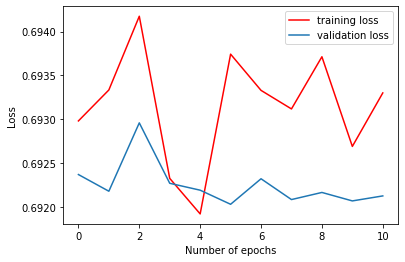

In [45]:
#Plotting the graph for training and validation loss
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(hist.history['loss'],'r',label='training loss')
plt.plot(hist.history['val_loss'],label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

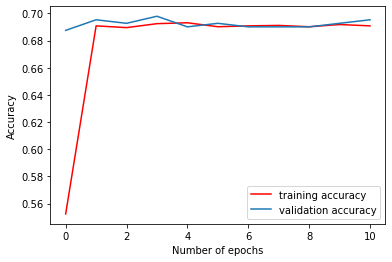

In [46]:
#Plotting the graph for training and validation accuracy
plt.locator_params(axis='x', integer=True, tight=True) 
plt.plot(hist.history['accuracy'],'r',label='training accuracy')
plt.plot(hist.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

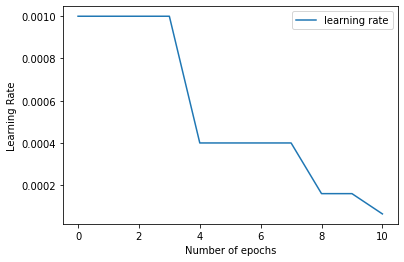

In [47]:
#Plotting the graph for learning rate
plt.locator_params(axis='x', integer=True, tight=True)
plt.plot(hist.history['lr'],label='learning rate')
plt.xlabel('Number of epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [49]:
#Evaluating the model on the testing dataset
testingAccuracy = finalXceptionModel.evaluate(test_dataset)
print("The Xception model has a testing accuracy of:", testingAccuracy[1]*100, "%")

10/10 [==============================] - 4s 388ms/step - loss: 0.6921 - accuracy: 0.6923
The Xception model has a testing accuracy of: 69.2307710647583 %
